In [7]:
import pandas as pd 
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Read the dataset
df = pd.read_csv('dataset.csv')
df.head()

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00


In [13]:
# Model 2: Dynamic Pricing Model with Mathematical Demand Function

# Data preprocessing
BASE_PRICE = 10.0
df['occupancy_ratio'] = df['Occupancy'] / df['Capacity']

# Feature engineering
df['Hour'] = pd.to_datetime(df['LastUpdatedTime']).dt.hour
df['DayOfWeek'] = pd.to_datetime(df['LastUpdatedDate'], format='%d-%m-%Y').dt.dayofweek

# Encode categorical variables properly
print("Unique traffic conditions:", df['TrafficConditionNearby'].unique())
print("Unique vehicle types:", df['VehicleType'].unique())

# Fix encoding - handle all actual values in the dataset
df['TrafficCondition_encoded'] = df['TrafficConditionNearby'].map({
    'low': 0,
    'average': 1, 
    'high': 2
})

df['VehicleType_encoded'] = df['VehicleType'].map({
    'car': 0,
    'bike': 1, 'cycle': 1,  # treat cycle same as bike
    'truck': 2
})

# Fill any remaining missing values with defaults
df['TrafficCondition_encoded'].fillna(1, inplace=True)  # Default to medium
df['VehicleType_encoded'].fillna(0, inplace=True)       # Default to car

print("Data preprocessing complete")
print("Traffic encoding distribution:", df['TrafficCondition_encoded'].value_counts())
print("Vehicle encoding distribution:", df['VehicleType_encoded'].value_counts())

C:\Users\AstralK\AppData\Local\Temp\ipykernel_13388\1227120071.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['LastUpdatedTime']).dt.hour
C:\Users\AstralK\AppData\Local\Temp\ipykernel_13388\1227120071.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TrafficCondition_encoded'].fillna(1, inplace=True)  # Default to medium
C:\Users\AstralK\AppData\L

Unique traffic conditions: ['low' 'high' 'average']
Unique vehicle types: ['car' 'bike' 'truck' 'cycle']
Data preprocessing complete
Traffic encoding distribution: TrafficCondition_encoded
0    7793
1    6438
2    4137
Name: count, dtype: int64
Vehicle encoding distribution: VehicleType_encoded
0    11166
1     5393
2     1809
Name: count, dtype: int64


In [14]:
# Mathematical Demand Function Construction - Complex Dynamic Model
def calculate_demand_factor(occupancy_ratio, queue_length, traffic_level, special_day, vehicle_type, hour, day_of_week):
    """
    Complex mathematical demand function with dynamic coefficients
    Ensures smooth and bounded price variations (0.5x to 2x base price)
    """
    
    # Handle NaN and edge cases
    if pd.isna(occupancy_ratio) or pd.isna(queue_length) or pd.isna(traffic_level) or pd.isna(vehicle_type) or pd.isna(hour):
        return 1.0  # Return neutral factor for missing data
    
    # Ensure valid inputs
    occupancy_ratio = max(0, min(1, float(occupancy_ratio)))
    queue_length = max(0, float(queue_length))
    traffic_level = max(0, min(2, float(traffic_level)))
    hour = max(0, min(23, float(hour)))
    vehicle_type = int(vehicle_type) if not pd.isna(vehicle_type) else 0
    special_day = 1 if special_day else 0
    day_of_week = int(day_of_week) if not pd.isna(day_of_week) else 0
    
    # Dynamic weights that change based on time and conditions
    time_factor = np.sin(hour * np.pi / 12) * 0.3 + 0.7
    weekend_factor = 1.2 if day_of_week >= 5 else 1.0
    
    # Exponential occupancy impact (non-linear)
    occupancy_component = (occupancy_ratio ** 1.5) * 0.35 * time_factor
    
    # Queue length with exponential growth (congestion penalty)
    queue_normalized = min(queue_length / 15.0, 1.0)
    queue_component = (queue_normalized ** 2) * 0.25 * (1 + traffic_level * 0.1)
    
    # Traffic multiplier effect
    traffic_multiplier = 1 + (traffic_level / 2.0) * 0.2
    
    # Special day surge with time dependency
    special_surge = special_day * (0.15 + 0.05 * np.sin(hour * np.pi / 6))
    
    # Vehicle type dynamic pricing
    vehicle_multipliers = {
        0: 1.0,                                    # car
        1: 0.7 + 0.1 * np.cos(hour * np.pi / 8),  # bike
        2: 1.3 + 0.2 * time_factor                # truck
    }
    vehicle_adjustment = vehicle_multipliers.get(vehicle_type, 1.0)
    
    # Complex interaction terms
    congestion_interaction = occupancy_ratio * queue_normalized * traffic_level * 0.1
    peak_interaction = time_factor * occupancy_ratio * (1 + special_day * 0.3)
    
    # Combine all components
    raw_demand = (
        occupancy_component + 
        queue_component + 
        special_surge + 
        congestion_interaction + 
        peak_interaction
    ) * traffic_multiplier * vehicle_adjustment * weekend_factor
    
    # Ensure finite values
    raw_demand = np.clip(raw_demand, 0, 5)
    
    # Advanced sigmoid with adjustable steepness
    steepness = 2.5 + occupancy_ratio * 1.5
    sigmoid_input = raw_demand * steepness - 1.2
    
    # Stable tanh calculation
    normalized_demand = np.tanh(np.clip(sigmoid_input, -10, 10))
    demand_factor = 0.5 + 1.5 * (normalized_demand + 1) / 2
    
    # Final safety check
    return np.clip(demand_factor, 0.5, 2.0)

# Check for missing values and fill them
print("Checking for missing values:")
print(df[['occupancy_ratio', 'QueueLength', 'TrafficCondition_encoded', 'VehicleType_encoded']].isnull().sum())

# Fill any missing values
df['TrafficCondition_encoded'].fillna(1, inplace=True)  # Default to medium traffic
df['VehicleType_encoded'].fillna(0, inplace=True)       # Default to car
df['IsSpecialDay'].fillna(0, inplace=True)              # Default to regular day

# Apply the complex mathematical demand function
df['demand_factor'] = df.apply(lambda row: calculate_demand_factor(
    row['occupancy_ratio'], row['QueueLength'], row['TrafficCondition_encoded'],
    row['IsSpecialDay'], row['VehicleType_encoded'], row['Hour'], row['DayOfWeek']
), axis=1)

# Create target price
df['target_price'] = BASE_PRICE * df['demand_factor']

print("Complex mathematical demand function applied")
print(f"Price range: ${df['target_price'].min():.2f} - ${df['target_price'].max():.2f}")
df['target_price'].describe()

Checking for missing values:
occupancy_ratio             0
QueueLength                 0
TrafficCondition_encoded    0
VehicleType_encoded         0
dtype: int64


C:\Users\AstralK\AppData\Local\Temp\ipykernel_13388\690245494.py:78: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TrafficCondition_encoded'].fillna(1, inplace=True)  # Default to medium traffic
C:\Users\AstralK\AppData\Local\Temp\ipykernel_13388\690245494.py:79: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

Complex mathematical demand function applied
Price range: $6.32 - $20.00


count    18368.000000
mean        14.983606
std          4.377978
min          6.315802
25%         11.022829
50%         15.977810
75%         19.274042
max         20.000000
Name: target_price, dtype: float64

In [4]:
# Feature selection for dynamic model
dynamic_features = [
    'occupancy_ratio',
    'QueueLength', 
    'TrafficCondition_encoded',
    'IsSpecialDay',
    'VehicleType_encoded',
    'Hour',
    'DayOfWeek',
    'demand_factor'  # Include the calculated demand factor as a feature
]

X = df[dynamic_features]
y = df['target_price']

print("Feature matrix shape:", X.shape)
print("Dynamic features:", dynamic_features)

Feature matrix shape: (18368, 8)
Dynamic features: ['occupancy_ratio', 'QueueLength', 'TrafficCondition_encoded', 'IsSpecialDay', 'VehicleType_encoded', 'Hour', 'DayOfWeek', 'demand_factor']


In [5]:
# Dynamic Pricing Model using LightGBM
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lgb_params = {
    'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt',
    'num_leaves': 60, 'learning_rate': 0.02, 'feature_fraction': 0.95,
    'bagging_fraction': 0.9, 'lambda_l1': 0.1, 'lambda_l2': 0.1,
    'verbose': 0, 'random_state': 42
}

train_data = lgb.Dataset(X_train, label=y_train)
dynamic_model = lgb.train(lgb_params, train_data, num_boost_round=150)

y_pred_test = np.clip(dynamic_model.predict(X_test), BASE_PRICE * 0.5, BASE_PRICE * 2.0)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Dynamic Model RMSE: {test_rmse:.4f}")

# Feature importance
importance_df = pd.DataFrame({
    'feature': dynamic_features,
    'importance': dynamic_model.feature_importance()
}).sort_values('importance', ascending=False)

importance_df

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

ValueError: Input contains NaN.

NameError: name 'importance_df' is not defined

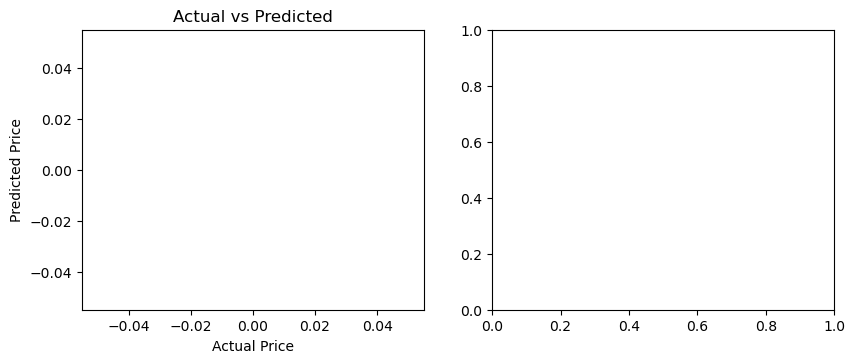

In [6]:
# Key Visualizations
plt.figure(figsize=(15, 8))

# Actual vs Predicted
plt.subplot(2, 3, 1)
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted')

# Feature Importance
plt.subplot(2, 3, 2)
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('Feature Importance')

# Price Distribution
plt.subplot(2, 3, 3)
plt.hist(df['target_price'], bins=30, alpha=0.7, color='green')
plt.axvline(x=BASE_PRICE * 0.5, color='red', linestyle='--', label='0.5x Base')
plt.axvline(x=BASE_PRICE * 2.0, color='red', linestyle='--', label='2x Base')
plt.xlabel('Price')
plt.title('Price Distribution')
plt.legend()

# Demand Factor vs Price
plt.subplot(2, 3, 4)
plt.scatter(df['demand_factor'], df['target_price'], alpha=0.4)
plt.xlabel('Demand Factor')
plt.ylabel('Price')
plt.title('Demand Factor vs Price')

# Hourly Pattern
plt.subplot(2, 3, 5)
hourly_avg = df.groupby('Hour')['target_price'].mean()
plt.plot(hourly_avg.index, hourly_avg.values, marker='o')
plt.xlabel('Hour')
plt.ylabel('Average Price')
plt.title('Hourly Pricing Pattern')

# Price by Vehicle Type
plt.subplot(2, 3, 6)
vehicle_labels = ['Car', 'Bike', 'Truck']
box_data = [df[df['VehicleType_encoded'] == i]['target_price'] for i in range(3)]
plt.boxplot(box_data, labels=vehicle_labels)
plt.ylabel('Price')
plt.title('Price by Vehicle Type')

plt.tight_layout()
plt.show()

print(f"\nModel Summary:")
print(f"Price Range: ${df['target_price'].min():.2f} - ${df['target_price'].max():.2f}")
print(f"Bounded: {(df['target_price'] >= BASE_PRICE * 0.5).all() and (df['target_price'] <= BASE_PRICE * 2.0).all()}")

In [ ]:
# Dynamic Pricing Function for Deployment
def dynamic_pricing_function(occupancy, capacity, queue_length, traffic_condition, 
                            special_day, vehicle_type, hour, day_of_week):
    """Real-time dynamic pricing with complex mathematical demand function"""
    
    occupancy_ratio = occupancy / capacity
    traffic_encoded = {'Low': 0, 'Medium': 1, 'High': 2}.get(traffic_condition, 1)
    vehicle_encoded = {'car': 0, 'bike': 1, 'truck': 2}.get(vehicle_type, 0)
    special_encoded = 1 if special_day else 0
    
    # Use complex demand function
    demand_factor = calculate_demand_factor(
        occupancy_ratio, queue_length, traffic_encoded, special_encoded, 
        vehicle_encoded, hour, day_of_week
    )
    
    # LightGBM prediction
    features = np.array([[occupancy_ratio, queue_length, traffic_encoded, special_encoded,
                         vehicle_encoded, hour, day_of_week, demand_factor]])
    
    predicted_price = dynamic_model.predict(features)[0]
    final_price = np.clip(predicted_price, BASE_PRICE * 0.5, BASE_PRICE * 2.0)
    
    return final_price, demand_factor

# Test scenarios
test_cases = [
    (30, 100, 1, 'Low', False, 'bike', 9, 1),      # Low demand morning
    (85, 100, 6, 'High', False, 'car', 17, 1),     # Rush hour
    (95, 100, 10, 'High', True, 'truck', 19, 5),   # Peak weekend
]

print("=== Dynamic Pricing Test ===")
for i, case in enumerate(test_cases):
    price, demand = dynamic_pricing_function(*case)
    print(f"Case {i+1}: ${price:.2f} (Factor: {demand:.2f}, Multiplier: {price/BASE_PRICE:.2f}x)")
    print(f"  Conditions: {case[0]}/{case[1]} occupancy, {case[2]} queue, {case[3]} traffic")
    print()